In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import talib as ta # conda activate cryt310 
from aver5_funcs import get_data
import pickle 
from scipy import stats
import requests,time
from tqdm import tqdm
from time import sleep, perf_counter
from threading import Thread
def get_time_before(minutes=10):
    return (int(time.time())-minutes*60)*1000
with open("9_0_subset_symbols_24hrchange.pkl","rb") as f:
    subset_symbols = pickle.load(f)

In [2]:
len(subset_symbols)

346

In [3]:
int(time.time())*1000

1690254090000

In [4]:
start_time = 1690021502000 #2023-07-22 18:30:00
offset=8*3600*1000

In [5]:
5*1000/60/24

3.472222222222222

# todo:
- do predictions for top 10 tickers at 5m resolution
- then use hourly/30m-ly 24hr change to find datasets to validate this analysis/prediction

In [6]:
def task2(id):
    start_time = 1690021502000-1050*3600*1000-3600_000*24*30 #2023-07-22 18:30:00
    offset=8*3600*1000
    sleep(id*0.15)# 0.05 works
    dfmpl0 =get_data(subset_symbols[id]+"USDT","5m",limit=1000,start_time=start_time-3600_000*24,offset=offset)
    sleep(0.075) # only for 5m interval
    dfmpl1 =get_data(subset_symbols[id]+"USDT","5m",limit=1000,start_time=dfmpl0.iloc[-1].name.value//1000_000-offset+5*60_000,offset=offset)
    dff=pd.concat([dfmpl0,dfmpl1])
    data_fetched2[id]=(dff.iloc[0:2000-24*60//5].copy(),dff.iloc[24*60//5:].copy())
    if id%10==0:
        print(f'{id}',end=",")

In [7]:
data_fetched2 = [[None,None] for v in subset_symbols]
task2(1)

In [8]:
data_fetched2[1][1].iloc[-1]

Open           0.4267
High           0.4269
Low            0.4258
Close          0.4259
Volume    810758.0000
Name: 2023-05-15 23:05:00, dtype: float64

In [9]:
%%time
if True:
    data_fetched2 = [[None,None] for v in subset_symbols]
    start_time = perf_counter() 
    threads = []
    for n in range(len(subset_symbols)):
        t = Thread(target=task2, args=(n,))
        threads.append(t)
        t.start() 
    for t in threads:
        t.join()
    end_time = perf_counter()
    print(f'\ntook {end_time- start_time: 0.2f} s to complete.')
    #with open("9_0_5_data_fetched2.pkl","wb") as f:
    #    pickle.dump(data_fetched2,f)
else:
    #with open("9_0_5_data_fetched2.pkl","rb") as f:
    #    data_fetched2 = pickle.load(f)
    pass

0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,
took  52.63 s to complete.
CPU times: total: 9.05 s
Wall time: 52.6 s


#  trying to predict the order of top 10 tickers, assuming the current fluctuations are small.

- for all tickers, find the 5m candles in the past 24hrs and then calculate the % change wrt current time. 
- get the order of tickers for the next 5,10,15mins.

- see if this order correspond to the actual results

In [10]:
len(subset_symbols)

346

In [11]:
tickerpair="STMXUSDT"
interval="5m"
assert False
df_5m_befor = get_data(tickerpair,interval,limit=5,start_time=start_time-3600_000*24,offset=offset)
df_5m_after = get_data(tickerpair,interval,limit=5,start_time=start_time,offset=offset)

print("\ndf_5m_befor\n")
print(df_5m_befor)
print("\ndf_5m_after\n")
print(df_5m_after)

print("\ncurrent ticker time",df_5m_after.iloc[-1].name,"\n")

for i in range(len(df_5m_befor)):
    print(f"{(df_5m_after.iloc[-1].Close - df_5m_befor.iloc[i].Close)/df_5m_befor.iloc[i].Close:.4%}",df_5m_befor.iloc[i].name)

AssertionError: 

In [12]:
%%time
lengs=[]
for i in range(len(data_fetched2)):
    dfmpl_befor, dfmpl_after = data_fetched2[i]
    lengs.append(len(dfmpl_befor))
    lengs.append(len(dfmpl_after))
assert all(np.asarray(lengs)==len(dfmpl_befor)) # all df have the same length

CPU times: total: 0 ns
Wall time: 2 ms


In [13]:
%%time
hr24change = [(dfmpl_after.Close.values-dfmpl_befor.Close.values)/dfmpl_befor.Close.values for dfmpl_befor, dfmpl_after in data_fetched2]
hr24change = np.asarray(hr24change)
dfmpl_befor, dfmpl_after = data_fetched2[2]
argsort = np.argsort(-hr24change,axis=0)

CPU times: total: 31.2 ms
Wall time: 116 ms


Text(0, 0.5, 'argsort top gaining tickers in 24hr')

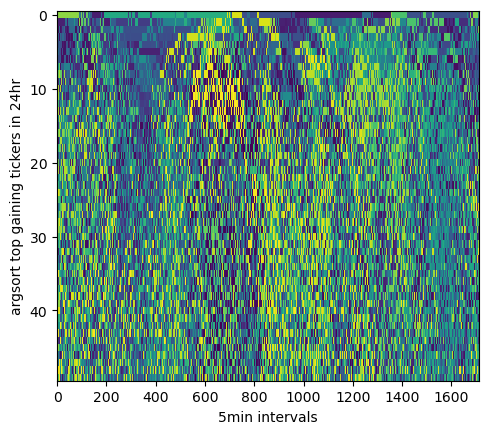

In [14]:
plt.imshow(argsort[:50],aspect=30,interpolation="none")
plt.xlabel("5min intervals")
plt.ylabel("argsort top gaining tickers in 24hr")

#### find all ticker,time pairs when the ticker first become top gainer. what is the candlestick immediately afterwards?

In [44]:
argsort[0][:35]

array([286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286,
       286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286,
       286, 286, 286, 286, 286, 286, 286, 286, 286], dtype=int64)

In [45]:
a1=np.diff(argsort[0])
a2=np.where(a1!=0)[0]+1
a3=np.where(a2)[0]
first_peaked_locs=a2[a3]
first_peaked_tickers=argsort[0][first_peaked_locs]

a1[:35]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [46]:
a2[:35]

array([ 91,  92,  93,  96,  97,  99, 100, 101, 102, 103, 104, 105, 111,
       116, 125, 126, 130, 131, 132, 135, 136, 137, 142, 177, 180, 182,
       192, 284, 285, 287, 289, 290, 291, 292, 293], dtype=int64)

In [47]:
a3[:35]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34], dtype=int64)

In [20]:
for loc,ticker in enumerate(argsort[0]):
    if a2[0]-5 < loc<a2[5]+3:
        print(loc,ticker,"first" if loc in first_peaked_locs else "")

87 286 
88 286 
89 286 
90 286 
91 125 first
92 286 first
93 125 first
94 125 
95 125 
96 16 first
97 262 first
98 262 
99 277 first
100 26 first
101 262 first


In [6]:
assert False
for days in [10,20,30,50,60,70,140,200,210]:
    print(f"days{days}")
    def task2(id):
        start_time = 1690021502000-1050*3600*1000-3600_000*24*days #2023-07-22 18:30:00
        offset=8*3600*1000
        sleep(id*0.25)# 0.05 works
        dfmpl0 =get_data(subset_symbols[id]+"USDT","5m",limit=1000,start_time=start_time-3600_000*24,offset=offset)
        sleep(0.12) # only for 5m interval
        dfmpl1 =get_data(subset_symbols[id]+"USDT","5m",limit=1000,start_time=dfmpl0.iloc[-1].name.value//1000_000-offset+5*60_000,offset=offset)
        dff=pd.concat([dfmpl0,dfmpl1])
        data_fetched2[id]=(dff.iloc[0:2000-24*60//5].copy(),dff.iloc[24*60//5:].copy())
        if id%10==0:
            print(f'{id}',end=",")
    data_fetched2 = [[None,None] for v in subset_symbols]
    start_time = perf_counter() 
    threads = []
    for n in range(len(subset_symbols)):
        t = Thread(target=task2, args=(n,))
        threads.append(t)
        t.start() 
    for t in threads:
        t.join()
    end_time = perf_counter()
    print(f'\ntook {end_time- start_time: 0.2f} s to complete.')
    with open(f"9_0_5_analysisdata\data_fetched2_{days:04d}days.pkl","wb") as f:
        pickle.dump(data_fetched2,f)
    sleep(90)

days10
0,10,


KeyboardInterrupt



# run downloaded data

In [202]:
days=20 #[10,20,30,50,60,70,140,200,210]
with open(f"9_0_5_analysisdata\data_fetched2_{days:04d}days.pkl","rb") as f:
    data_fetched2 = pickle.load(f)
    
lengs=[]
for i in range(len(data_fetched2)):
    dfmpl_befor, dfmpl_after = data_fetched2[i]
    lengs.append(len(dfmpl_befor))
    lengs.append(len(dfmpl_after))
assert all(np.asarray(lengs)==len(dfmpl_befor)) # all df have the same length

hr24change = [(dfmpl_after.Close.values-dfmpl_befor.Close.values)/dfmpl_befor.Close.values for dfmpl_befor, dfmpl_after in data_fetched2]
hr24change = np.asarray(hr24change)
argsort = np.argsort(-hr24change,axis=0)

a1=np.diff(argsort[0])
a2=np.where(a1!=0)[0]+1
a3=np.where(a2)[0]
first_peaked_locs=a2[a3]
first_peaked_tickers=argsort[0][first_peaked_locs]

In [203]:
argsort.shape

(346, 1712)

In [222]:
350*0.05

17.5

CPU times: total: 312 ms
Wall time: 423 ms


Text(0.5, 1.0, 'mean highs=2.23%')

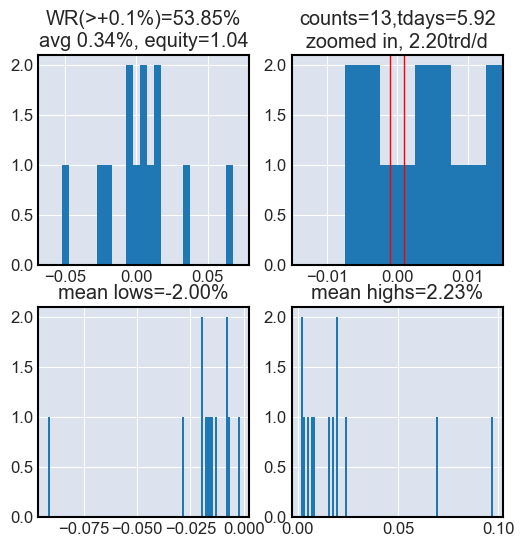

In [168]:
%%time
close_over_open=[]
lows_over_open=[]
highs_over_open=[]
choosen_loc_ticker=[]
equity=[1]
for loc0,ticker in zip(first_peaked_locs,first_peaked_tickers):
    df=data_fetched2[ticker][1]
    gain=(df.iloc[loc0].Close-df.iloc[loc0].Open)/df.iloc[loc0].Open
    
    if gain<0.03:
        continue
    pullback = (df.iloc[loc0].High - df.iloc[loc0].Close)/(df.iloc[loc0].High - df.iloc[loc0].Open)
    if pullback>0.3:
        continue
    
    loc=loc0+1
    if (loc>=len(df)) or (loc<=0):
        continue
    
    choosen_loc_ticker.append((loc0,ticker))
    gain=(df.iloc[loc].Close-df.iloc[loc].Open)/df.iloc[loc].Open
    drawdown=(df.iloc[loc].Low-df.iloc[loc].Open)/df.iloc[loc].Open
    upside=(df.iloc[loc].High-df.iloc[loc].Open)/df.iloc[loc].Open
    equity.append(equity[-1]*(1+gain))
    close_over_open.append(gain)
    lows_over_open.append(drawdown)
    highs_over_open.append(upside)
fig,axx=plt.subplots(2,2,figsize=(6,6))
axx=axx.ravel()
bins=np.arange(min(close_over_open)-0.01,max(close_over_open)+0.01,0.005)
_,bins,_ = axx[0].hist(close_over_open,bins=bins);
strr =f"WR(>+0.1%)={np.mean(np.asarray(close_over_open)>0.001):.2%}"
strr+=f"\navg {np.mean(close_over_open):.2%}, equity={equity[-1]:.2f}"
axx[0].set_title(strr)
ax=axx[1]
ax.hist(close_over_open,bins=bins);
ax.set_xlim(-0.015,0.015)
ax.axvline(0.001,c="r",lw=1)
ax.axvline(-0.001,c="r",lw=1);
dfmpl_befor, dfmpl_after = data_fetched2[0]
tdays=(dfmpl_after.iloc[-1].name.value-dfmpl_after.iloc[0].name.value)//1_000_000_000//3600/24
ax.set_title(f"counts={len(close_over_open)},tdays={tdays:.2f}\nzoomed in, {len(close_over_open)/tdays:.2f}trd/d")
ax=axx[2]
ax.hist(lows_over_open,bins=100)
ax.set_title(f"mean lows={np.mean(lows_over_open):.2%}")
ax=axx[3]
ax.hist(highs_over_open,bins=100)
ax.set_title(f"mean highs={np.mean(highs_over_open):.2%}")

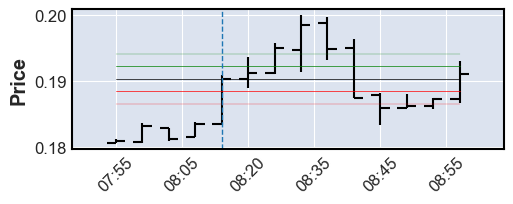

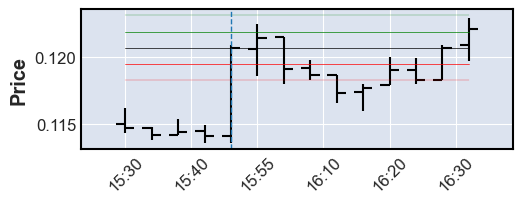

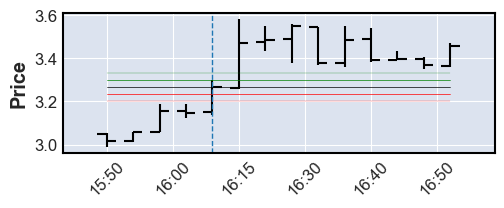

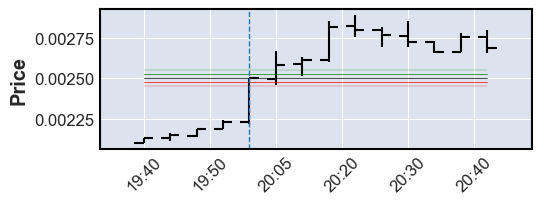

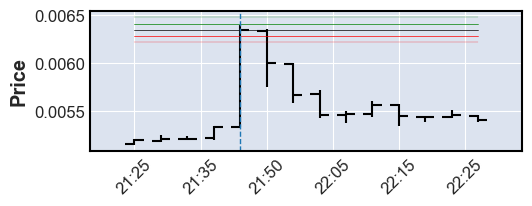

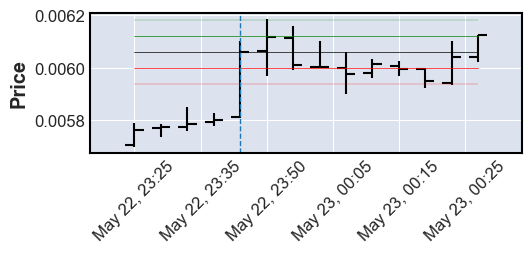

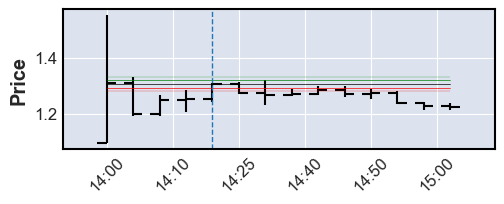

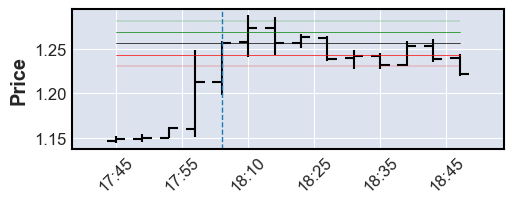

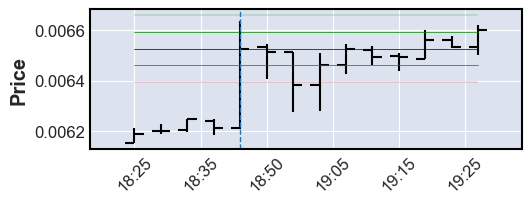

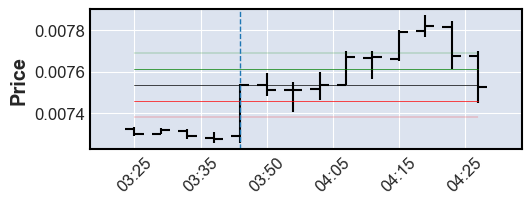

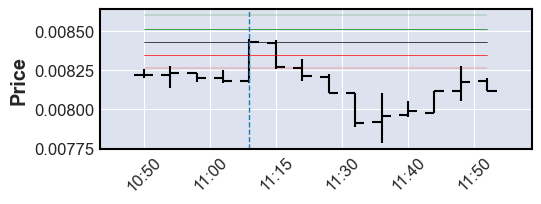

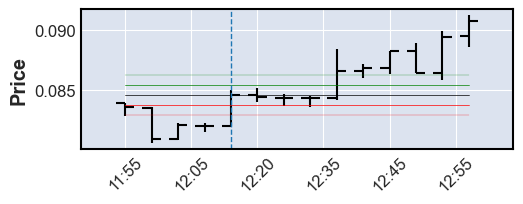

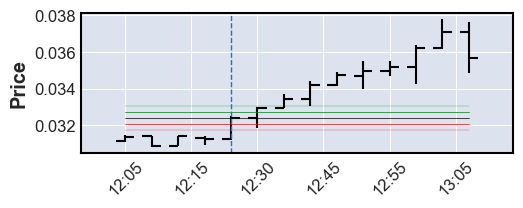

In [169]:
for loc,ticker_id in choosen_loc_ticker[:15]:
    
    x=4
    dfmpl = data_fetched2[ticker_id][1].iloc[loc-x:loc+10]
    apds = [ mpf.make_addplot(dfmpl.Close*0+dfmpl.iloc[x].Close,panel=0,color='k',type='line',width=0.5, secondary_y=False),
            mpf.make_addplot(dfmpl.Close*0+dfmpl.iloc[x].Close*1.01,panel=0,color='g',type='line',width=0.5, secondary_y=False),
            mpf.make_addplot(dfmpl.Close*0+dfmpl.iloc[x].Close*0.99,panel=0,color='r',type='line',width=0.5, secondary_y=False),
            mpf.make_addplot(dfmpl.Close*0+dfmpl.iloc[x].Close*1.02,panel=0,color='g',type='line',width=0.2, secondary_y=False),
            mpf.make_addplot(dfmpl.Close*0+dfmpl.iloc[x].Close*0.98,panel=0,color='r',type='line',width=0.2, secondary_y=False),
           ]
    fig, axlist =mpf.plot(dfmpl,addplot=apds,#ylabel=f"{tickerpair} Price ({interval})",
            #vlines=dict(vlines=vlines,linewidths=0.01,alpha=0.3,colors="r"),
             returnfig=True,figsize=(6,2),warn_too_much_data=2000)
    axlist[0].axvline(0+x,ls="--",lw="1")

# - every: 1 to 4th minute download previous data.
# - every 4th minute, download all new data and sort them
# - then at 4:40/4:55 second, download only the top 10 tickers
# - then if any other ticker becomes the first ticker, enter position

# - i need to change the price action trader to be +-1% and +-2%, sl-2%, tp levels at +2% slow up move at +1%

In [171]:
350/3/60

1.9444444444444444

In [172]:
1000*5/60/24

3.472222222222222

In [204]:
def get_time_before(minutes=10):
    return int((int(time.time())-minutes*60)*1000)
start_time = get_time_before(15)#24*60)
offset=8*3600*1000
df0 = get_data(subset_symbols[0]+"USDT","5m",limit=3,start_time=start_time-3600_000*24,offset=offset)

df = get_data(subset_symbols[0]+"USDT","5m",limit=3,start_time=start_time,offset=offset)
print(df0)
print(df)

                         Open      High       Low     Close    Volume
Date                                                                 
2023-07-22 23:20:00  29861.35  29867.99  29861.34  29867.98  15.18425
2023-07-22 23:25:00  29867.98  29881.99  29867.98  29881.98  20.46181
2023-07-22 23:30:00  29881.98  29881.99  29863.81  29870.65  47.90477
                         Open      High       Low     Close    Volume
Date                                                                 
2023-07-23 23:20:00  29904.01  29904.01  29898.27  29898.27  21.64138
2023-07-23 23:25:00  29898.27  29898.28  29894.00  29894.01  17.20468
2023-07-23 23:30:00  29894.01  29902.02  29894.00  29902.01  19.28599


In [189]:
df0.iloc[0].name.value

1690067700000000000

In [190]:
df.iloc[0].name.value

1690154100000000000

In [217]:
arr1=[i for i in range(500000)]+[1]
arr2=[i for i in range(500000)]+[2]

In [218]:
%%time
all(i1==i2 for i1,i2 in zip(arr1,arr2))

CPU times: total: 0 ns
Wall time: 0 ns


False

# END OF FILE